In [49]:
import pandas as pd   
import numpy as np              
import pickle
import time

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

In [63]:
df = pd.read_csv('online_shoppers_intention.csv')

cat_vars = ['OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend', 'Month']
df = pd.get_dummies(df, columns=cat_vars)

X = df.drop(columns='Revenue')
y = df['Revenue']

print(X['Browser_1'])
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0) 

0         True
1        False
2         True
3        False
4        False
         ...  
12318    False
12319    False
12320    False
12321    False
12322    False
Name: Browser_1, Length: 12323, dtype: bool


In [51]:
# Create functions
def get_classification_report(model_y_pred, file_name):
  report = classification_report(test_y, model_y_pred, output_dict = True)
  report_df = pd.DataFrame(report)
  display(report_df)
    
  report_df.to_csv(file_name)

  return report_df

def get_and_plot_confusion_matrix(model_y_pred, model, file_name):
  cm = confusion_matrix(test_y, model_y_pred, labels = model.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.classes_)

  fig, ax = plt.subplots(figsize = (5, 5))
  plt.rcParams.update({'font.size': 12})
  disp.plot(cmap = 'Blues', ax = ax)
  fig.savefig(file_name, bbox_inches = 'tight')

  return cm

def get_and_plot_feature_importance(model, file_name):
  importance = model.feature_importances_
  feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)), columns = ['Feature', 'Importance'])
  feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

  plt.figure(figsize=(10, 5))
  plt.barh(feature_imp['Feature'], feature_imp['Importance'], color = ['lightgrey', 'skyblue'])
  plt.xlabel('Importance')
  plt.title('Feature Importance for Fetal Health Predictions') 
  plt.tight_layout()
  plt.savefig(file_name)

  return feature_imp

In [52]:
base_estimator = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(estimator=base_estimator, random_state=0)

ada_clf.fit(train_X, train_y)
y_pred_ada_clf = ada_clf.predict(test_X)

In [53]:
hyper_params = {'estimator__min_samples_leaf': [10, 20, 30, 40, 100],
                'estimator__max_depth': [5,10,13,15],
                'n_estimators': [50, 100, 150]}

folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)

model_cv = GridSearchCV(estimator = ada_clf,
                        param_grid = hyper_params,
                        scoring = 'f1_weighted',
                        cv = folds,
                        verbose = 1,
                        n_jobs = -1) 

In [54]:
start = time.time()           
model_cv.fit(train_X, train_y)
stop = time.time()             
print(f"Training time: {stop - start}s")

print('Initial score: ', model_cv.best_score_)
print('Initial parameters: ', model_cv.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R

Training time: 308.0696818828583s
Initial score:  0.8862659517119227
Initial parameters:  {'estimator__max_depth': 15, 'estimator__min_samples_leaf': 10, 'n_estimators': 150}


In [55]:
# Tune hyperparamters
hyper_params_new = {'estimator__min_samples_leaf': list(range(2, 12)),
                    'estimator__max_depth': list(range(15, 24)),
                    'n_estimators': list(range(2, 12))}

# Call GridSearchCV()
model_cv = GridSearchCV(estimator = ada_clf,
                        param_grid = hyper_params_new,
                        scoring= 'f1_weighted',
                        cv = folds,
                        refit=True,
                        verbose = 1,
                        n_jobs = -1) # Will utilize all available CPUs

In [56]:
# Fit tuned model
start = time.time()      
model_cv.fit(train_X, train_y)
stop = time.time()           
print(f"Training time: {stop - start}s")

print('Improved score: ', model_cv.best_score_)
print('Improved parameters: ', model_cv.best_params_)

best_ada_clf = model_cv.best_estimator_

y_pred_best_ada_clf = best_ada_clf.predict(test_X)

Fitting 5 folds for each of 900 candidates, totalling 4500 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R

Training time: 229.87639117240906s
Improved score:  0.8863178443045714
Improved parameters:  {'estimator__max_depth': 17, 'estimator__min_samples_leaf': 2, 'n_estimators': 10}


,False,True,accuracy,macro avg,weighted avg
precision,0.924565,0.546599,0.863692,0.735582,0.867372
recall,0.913958,0.581769,0.863692,0.747864,0.863692
f1-score,0.919231,0.563636,0.863692,0.741434,0.865423
support,2092.000000,373.000000,0.863692,2465.000000,2465.000000


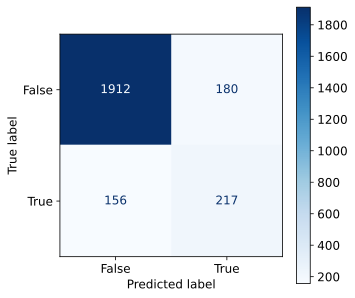

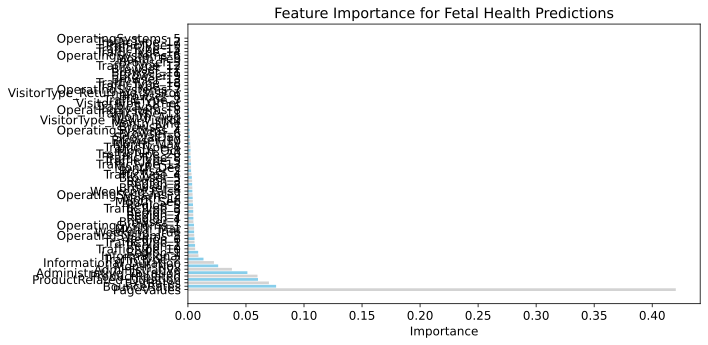

In [57]:

# Get classification report
ada_classification_df = get_classification_report(y_pred_ada_clf, 'class_report_ada.csv')

# Get confusion matrix
ada_cm = get_and_plot_confusion_matrix(y_pred_ada_clf, ada_clf, 'confusion_mat_ada.svg')

# Get feature importance
ada_feature_imp_df = get_and_plot_feature_importance(ada_clf, 'feat_imp_ada.svg')

In [58]:
ada_pickle = open('ada.pickle', 'wb') 
pickle.dump(ada_clf, ada_pickle) 
ada_pickle.close()